# Project 1. E-commerce

## Задание

### Условие и вопросы

Продакт-менеджер Василий попросил вас проанализировать совершенные покупки и ответить на следующие вопросы:

1. Сколько у нас пользователей, которые совершили покупку только один раз?

2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

3. По каждому товару определить, в какой день недели товар чаще всего покупается.

4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть. 

5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц. Описание подхода можно найти тут.

6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. Описание подхода можно найти тут.

### Входные данные

__olist_customers_datase.csv__ — таблица с уникальными идентификаторами пользователей

- __customer_id__ — позаказный идентификатор пользователя

- __customer_unique_id__ —  уникальный идентификатор пользователя  (аналог номера паспорта)

- __customer_zip_code_prefix__ —  почтовый индекс пользователя

- __customer_city__ —  город доставки пользователя

- __customer_state__ —  штат доставки пользователя

__olist_orders_dataset.csv__ —  таблица заказов

- __order_id__ —  уникальный идентификатор заказа (номер чека)

- __customer_id__ —  позаказный идентификатор пользователя

- __order_status__ —  статус заказа

- __order_purchase_timestamp__ —  время создания заказа

- __order_approved_at__ —  время подтверждения оплаты заказа

- __order_delivered_carrier_date__ —  время передачи заказа в логистическую службу

- __order_delivered_customer_date__ —  время доставки заказа

- __order_estimated_delivery_date__ —  обещанная дата доставки

__olist_order_items_dataset.csv__ —  товарные позиции, входящие в заказы

- __order_id__ —  уникальный идентификатор заказа (номер чека)

- __order_item_id__ —  идентификатор товара внутри одного заказа

- __product_id__ —  ид товара (аналог штрихкода)

- __seller_id__ — ид производителя товара

- __shipping_limit_date__ —  максимальная дата доставки продавцом для передачи заказа партнеру по логистике

- __price__ —  цена за единицу товара

- __freight_value__ —  вес товара

__Уникальные статусы заказов в таблице olist_orders_dataset:__

- __created__ —  создан
- __approved__ —  подтверждён
- __invoiced__ —  выставлен счёт
- __processing__ —  в процессе сборки заказа
- __shipped__ —  отгружен со склада
- __delivered__ —  доставлен пользователю
- __unavailable__ —  недоступен
- __canceled__ —  отменён

## Решение

### Импортируем библиотеки

In [100]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import io
import requests
from datetime import datetime
from datetime import timedelta
from urllib.parse import urlencode
import json
import urllib
from calendar import monthrange
from operator import attrgetter
import matplotlib.pyplot as plt

### 1. Используем API и загружаем csv файлы с яндекс диска

Используем api

In [101]:
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key_orders = 'https://disk.yandex.ru/d/0zWmh1bYP6REbw'
public_key_customers = 'https://disk.yandex.ru/d/QXrVDUoQvFhIcg'
public_key_items = 'https://disk.yandex.ru/d/xCsQ0FiC-Ue4Lg'

Получаем url и загружаем файл в df `orders`

In [102]:
final_url = base_url + urlencode(dict(public_key=public_key_orders)) 
response = requests.get(final_url)
download_url = response.json()['href']
 
download_response = requests.get(download_url) 
orders = pd.read_csv(download_url)

Получаем url и загружаем файл в df `customers`

In [103]:
final_url = base_url + urlencode(dict(public_key=public_key_customers)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 

download_response = requests.get(download_url) 
customers = pd.read_csv(download_url) 

Получаем url и загружаем файл в df `items`

In [104]:
final_url = base_url + urlencode(dict(public_key=public_key_items)) 
response = requests.get(final_url) 
download_url = response.json()['href'] 
 
download_response = requests.get(download_url) 
items = pd.read_csv(download_url) 

### 2. Проверим запись данных, соответствие типов данных и отсутствие null значений

In [110]:
orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


Видим, что значения времени в данных не соответствуют должному типу. Изменим тип на timestamp позже, в процессе выполнения расчетов.

In [113]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  string
 1   customer_id                    99441 non-null  string
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(6), string(2)
memory usage: 6.1+ MB


Изменим тип данных столбцов order_id, customer_id и order_status на string

In [114]:
orders[['order_id', 'customer_id', 'order_status']] = \
    orders[['order_id', 'customer_id', 'order_status']].astype('string')

Проверим наличие пропусков. Видим, что есть пропуски. Можем предположить, что некоторые заказы были отменены на этапах подтверждения оплаты заказа, передачи заказа в логистическую службу и доставки заказа.

In [115]:
orders.isna().any()

order_id                         False
customer_id                      False
order_status                     False
order_purchase_timestamp         False
order_approved_at                 True
order_delivered_carrier_date      True
order_delivered_customer_date     True
order_estimated_delivery_date    False
dtype: bool

Проверим наличие дубликатов

In [118]:
if orders.nunique()[0] < orders.shape[0]:
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликатов нет


Проверим другой датафрейм

In [121]:
customers.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


Видим, что некоторые данные не соответствуют должному типу

In [124]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  string
 1   customer_unique_id        99441 non-null  string
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  string
 4   customer_state            99441 non-null  string
dtypes: int64(1), string(4)
memory usage: 3.8 MB


Приведем данные к нужному типу

In [123]:
customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']] = \
    customers[['customer_id', 'customer_unique_id', 'customer_city', 'customer_state']].astype('string')

Проверим наличие пропусков. Пропусков нет

In [125]:
customers.isna().any()

customer_id                 False
customer_unique_id          False
customer_zip_code_prefix    False
customer_city               False
customer_state              False
dtype: bool

Проверим наличие дубликатов. Видим, что дубликатов нет

In [126]:
if customers.nunique()[0] < customers.shape[0]:
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликатов нет


Проверим последний датафрейм

In [128]:
items.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


Видим, что некоторые данные не соответствуют должному типу. Тип данных колонки shipping_limit_date приведем к формату timestamp позже, если эта колонка понадобится для расчетов

In [130]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  string 
 1   order_item_id        112650 non-null  int64  
 2   product_id           112650 non-null  string 
 3   seller_id            112650 non-null  string 
 4   shipping_limit_date  112650 non-null  object 
 5   price                112650 non-null  float64
 6   freight_value        112650 non-null  float64
dtypes: float64(2), int64(1), object(1), string(3)
memory usage: 6.0+ MB


In [129]:
items[['order_id', 'product_id', 'seller_id']] = \
    items[['order_id', 'product_id', 'seller_id']].astype('string')

Проверим наличие пропусков. Пропусков нет

In [132]:
items.isna().any()

order_id               False
order_item_id          False
product_id             False
seller_id              False
shipping_limit_date    False
price                  False
freight_value          False
dtype: bool

Проверим наличие дубликатов. Видим, что дубликаты есть

In [133]:
if items.nunique()[0] < items.shape[0]:
    print('Дубликаты есть')
else: print('Дубликатов нет')

Дубликаты есть


Видим, что товары отображаются в заказе поштучно, и в одном заказе может быть несколько одинаковых товаров. Например, в заказе fffb9224b6fc7c43ebb0904318b10b5f присутствуют три товара 43423cdffde7fda63d0414ed38c11a73 и максимальное время доставки у всех позиций одинаковое, так как товары были заказаны внутри одного заказа. Дубликаты убирать не будем

In [152]:
items[items.order_id.duplicated() == True].tail(6)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
112616,ffecd5a79a0084f6a592288c67e3c298,2,50fd2b788dc166edd20512370dac54df,8b321bb669392f5163d04c59e235e066,2018-03-05 20:15:27,21.9,15.79
112617,ffecd5a79a0084f6a592288c67e3c298,3,50fd2b788dc166edd20512370dac54df,8b321bb669392f5163d04c59e235e066,2018-03-05 20:15:27,21.9,15.79
112635,fff8287bbae429a99bb7e8c21d151c41,2,bee2e070c39f3dd2f6883a17a5f0da45,4e922959ae960d389249c378d1c939f5,2018-03-27 12:29:22,180.0,48.14
112641,fffb9224b6fc7c43ebb0904318b10b5f,2,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19
112642,fffb9224b6fc7c43ebb0904318b10b5f,3,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19
112643,fffb9224b6fc7c43ebb0904318b10b5f,4,43423cdffde7fda63d0414ed38c11a73,b1fc4f64df5a0e8b6913ab38803c57a9,2017-11-03 02:55:58,55.0,34.19


Из данных видно, что их можно джоинить друг с другом, так как orders связан с customers через customer_id, а items связан с orders через order_id

### Задание 1. Сколько у нас пользователей, которые совершили покупку только один раз?

Делаем мердж orders с customers, чтобы узнать уникальные id покупателей

In [153]:
orders_merge_with_customers = orders.merge(customers, on='customer_id', how='left')

Проверяем, замерджились ли датафреймы

In [154]:
orders_merge_with_customers.head(3)

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,af07308b275d755c9edb36a90c618231,47813,barreiras,BA
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO


Считаем, сколько уникальных пользователей совершили хотя бы одну покупку, исключая пользователей, которые не совершили ни одной покупки. За совершенную покупку на данном этапе будем считать факт наличия подтверждения заказа (`order_approved_at`), не учитывая отмену заказа на дальшейших этапах (опалата, доставка...)

Смотрим, имеются ли в дф покупатели, которые не совершили покупку.

In [155]:
orders_merge_with_customers.order_approved_at.isna().sum()

160

Видим, что 160 человек не подтвердили покупку

Исключаем 160 покупателей и формируем дф с количеством покупок пользователей.  
Группируем данные по `customer_unique_id` и агрегируем по количеству `order_approved_at`, чтобы узнать, сколько заказов сделал каждый покупатель.  

Отбираем только заказы с одной покупкой

In [156]:
how_many_approved_orders_per_client = \
     orders_merge_with_customers[orders_merge_with_customers.order_approved_at.isna() == False] \
    .groupby(['customer_unique_id'], as_index=False) \
    .agg({'order_approved_at':'count'}) \
    .rename(columns={'order_approved_at':'orders_num'})

clients_with_one_purchase = how_many_approved_orders_per_client \
    .query('orders_num == 1') \
    .orders_num.count()

Количество покупателей, совершивших одну покупку

In [157]:
clients_with_one_purchase

93049

### Ответ на задание 1:
Количество покупателей, совершивших только одну покупку равно __93049__

### Задание 2. Сколько заказов в месяц в среднем не доставляется по разным причинам (вывести детализацию по причинам)?

Проверяем тип данных столбцов с датами

In [158]:
orders.dtypes

order_id                         string
customer_id                      string
order_status                     string
order_purchase_timestamp         object
order_approved_at                object
order_delivered_carrier_date     object
order_delivered_customer_date    object
order_estimated_delivery_date    object
dtype: object

Создаем новый df, в котором исправим тип данных

In [160]:
orders_with_date_types = orders.copy()

Приводим столбец `order_approved_at` к типу данных "дата"

In [161]:
orders_with_date_types['order_approved_at'] = pd.to_datetime(orders_with_date_types['order_approved_at'])

Проверяем тип данных столбца `order_approved_at`

In [162]:
orders_with_date_types.dtypes

order_id                                 string
customer_id                              string
order_status                             string
order_purchase_timestamp                 object
order_approved_at                datetime64[ns]
order_delivered_carrier_date             object
order_delivered_customer_date            object
order_estimated_delivery_date            object
dtype: object

Вычислим количество месяцев в нашем df для того, чтобы посчитать, сколько в среднем в месяц не доставляется заказов

Вычитаем из самой ранней даты самую позднюю дату и делим на timedelta `M`  
Помещаем значение в переменную `months_num`

In [163]:
months_num = (orders_with_date_types.order_approved_at.max() - orders_with_date_types.order_approved_at.min()) \
    /np.timedelta64(1, 'M')

Группируем данные df'ма по `order_status`, исключая статус `"delivered"` (т.к. этот статус показывает нам, что товар был доставлен, а нас интересуют недоставленные товары) и считаем количество товаров через `count`

In [164]:
num_of_undelivered_orders = orders_with_date_types \
    .query("order_status != 'delivered'") \
    .groupby(['order_status'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'orders_num'}) \
    .sort_values('orders_num', ascending=False)

Смотрим df

In [165]:
num_of_undelivered_orders

,order_status,orders_num
5,shipped,1107
1,canceled,625
6,unavailable,609
3,invoiced,314
4,processing,301
2,created,5
0,approved,2


Сделаем проверку

In [166]:
orders_with_date_types[orders_with_date_types.order_status != 'delivered'].order_status.value_counts()

shipped        1107
canceled        625
unavailable     609
invoiced        314
processing      301
created           5
approved          2
Name: order_status, dtype: Int64

Создадим новую колонку и разделим значения количества заказов на количество месяцев, чтобы получить среднее

In [167]:
num_of_undelivered_orders['mean'] = round(num_of_undelivered_orders.orders_num / months_num ,2)

In [168]:
num_of_undelivered_orders

,order_status,orders_num,mean
5,shipped,1107,46.91
1,canceled,625,26.49
6,unavailable,609,25.81
3,invoiced,314,13.31
4,processing,301,12.76
2,created,5,0.21
0,approved,2,0.08


### Ответ на задание 2:

Итак, мы видим, что в среднем не доставляются:
- __46.91 заказа__ по причине того, что товар был отгружен со склада и находится на пути к покупателю
- __26.49 заказа__ по причине того, что заказ был отменен на каком-то этапе цепочки от создания заказа до его получения
- __25.81 заказа__ по причине того, что товар(или заказ) был не доступен
- __13.31 заказа__ по причине того, что счет еще не оплачен покупателем или заказ еще не был передан на сборку
- __12.76 заказа__ по причине того, что заказ находится в процессе сборки
- __0.21 заказа__ по причине того, что заказ еще не был подвержден
- __0.08 заказа__ по причине того, что заказ был подтвержден, но еще не был выставлен счет

### Задание 3. По каждому товару определить, в какой день недели товар чаще всего покупается.

Создаем пустой df и помещаем туда данные из df `orders`

In [169]:
orders_with_purchase_days = orders.copy()

Делаем мердж `orders_with_purchase_days` с `items`, чтобы узнать id товаров

In [170]:
orders_with_items_purchase_days = orders_with_purchase_days.merge(items, on='order_id', how='left')

Приводим тип данных колонки с датой покупки (`order_purchase_timestamp`) к типу даты

In [171]:
orders_with_items_purchase_days['order_purchase_timestamp'] = \
    pd.to_datetime(orders_with_items_purchase_days['order_purchase_timestamp'])

Так как нужно узнать, в какой день недели покупали товар чаще всего, то создаем колонку с днями недели

In [172]:
orders_with_items_purchase_days['weekday'] = \
    orders_with_items_purchase_days['order_purchase_timestamp'].dt.day_name()

Считаем, в какой день недели каждый товар чаще всего покупается. 
Так как нас интересует именно факт покупки товара, а не факт покупки и доставки товара покупателю, то за покупку будем считать наличие даты подтверждения заказа (`order_approved_at`). Исключаем заказы, которые не были подтверждены (`"created"`). Покупатель мог совершить покупку импульсивно или ошибочно и не подтвердить заказ в будущем) и заказы, у которых отсутствует дата подтверждения заказа (`order_approved_at`).

Считаем количество товаров

In [194]:
orders_num_max_day=orders_with_items_purchase_days \
    .query("order_status != 'created' & order_approved_at.isna() != True") \
    .groupby(['product_id', 'weekday'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'orders_num'})

Выводим id товаров и дни, в которые данный товар продавался максимальное количество раз. Если товар продавался одинакого много в разные дни, то будут выведены все дни с максимальным числом продаж

In [195]:
orders_num_max_day=orders_num_max_day.groupby(['product_id', 'weekday'], as_index=False).max() \
     .sort_values('orders_num', ascending=False)

### Ответ на Задание 3:

In [196]:
orders_num_max_day

,product_id,weekday,orders_num
15899,422879e10f46682990de24d770e7f83d,Wednesday,93
36507,99a4788cb24856965c36a24e339b6058,Monday,92
41039,aca2eb7d00ea1a7b8ebd4e68314663af,Thursday,89
41035,aca2eb7d00ea1a7b8ebd4e68314663af,Friday,87
41040,aca2eb7d00ea1a7b8ebd4e68314663af,Tuesday,85
...,...,...,...
24016,642e125cbc752b4eeb8faf442319c39f,Thursday,1
24019,64315bd8c0c47303179dd2e25b579d00,Saturday,1
24024,6432d844f2be41bb6f2fd279e23415da,Friday,1
24026,6435535083cf42eb1ce5d96f2c4d3482,Tuesday,1


### Задание 4. Сколько у каждого из пользователей в среднем покупок в неделю (по месяцам)? Не стоит забывать, что внутри месяца может быть не целое количество недель. Например, в ноябре 2021 года 4,28 недели. И внутри метрики это нужно учесть.

Создаем пустой df и помещаем туда данные из df `orders_merge_with_customers` (мердж из `orders` и `customers`)

In [197]:
task4_merge_orders_with_customers = orders_merge_with_customers.copy()

Приводим тип данных колонки с датой покупки (`order_purchase_timestamp`) к типу даты. Оставляем только дату (без времени) для подсчета количества покупок по дням

In [200]:
task4_merge_orders_with_customers['order_purchase_timestamp'] = \
    pd.to_datetime(task4_merge_orders_with_customers['order_purchase_timestamp']).dt.date

Считаем, сколько покупок совершил каждый покупатель в день.  
Так как нас интересует именно факт покупки товара, а не факт покупки и доставки товара покупателю, то за покупку будем считать наличие даты подтверждения заказа (`order_approved_at`). Исключаем заказы, которые не были подтверждены (`"created"`). Покупатель мог совершить покупку импульсивно или ошибочно и не подтвердить заказ в будущем) и заказы, у которых отсутствует дата подтверждения заказа (`order_approved_at`)

In [264]:
orders_number_per_client_and_day = task4_merge_orders_with_customers \
    .query("order_status != 'created' & order_approved_at.isna() != True") \
    .groupby(['customer_unique_id', 'order_purchase_timestamp'], as_index=False) \
    .agg({'order_id':'count'}) \
    .rename(columns={'order_id':'orders_num'}) \
    .sort_values('orders_num', ascending=False)

Создаем колонку с указанием даты )год + месяц), отдельно года и месяца совершения заказа покупателем

In [265]:
orders_number_per_client_and_day['date'] = \
    pd.DatetimeIndex(orders_number_per_client_and_day['order_purchase_timestamp']).strftime('%Y-%m')

In [266]:
orders_number_per_client_and_day['month'] = \
    pd.DatetimeIndex(orders_number_per_client_and_day['order_purchase_timestamp']).month

In [267]:
orders_number_per_client_and_day['year'] = \
    pd.DatetimeIndex(orders_number_per_client_and_day['order_purchase_timestamp']).year

С помощью цикла и функции `monthrange` определяем количество дней в месяце x и помещяем значение в список, а затем добавляем значения списка в колонку `week_num`

In [268]:
new_list = []
for x in orders_number_per_client_and_day.itertuples():
    new_list.append(monthrange(x.year, x.month)[1]/7)
orders_number_per_client_and_day['week_num'] = new_list

In [269]:
orders_number_per_client_and_day.head()

,customer_unique_id,order_purchase_timestamp,orders_num,date,month,year,week_num
7340,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01-05,6,2017-01,1,2017,4.428571
50771,83e7958a94bd7f74a9414d8782f87628,2017-01-05,4,2017-01,1,2017,4.428571
86627,e13e8b789e5a8e6fe1445f924a4ed4f6,2018-06-01,3,2018-06,6,2018,4.285714
71754,ba87a137c5191264841e0be40e53f4ed,2018-02-21,3,2018-02,2,2018,4.000000
59504,9aae8213ff9bc04cc3ce48b85f43a173,2018-05-27,3,2018-05,5,2018,4.428571


Проверим, имеются ли у нас данные за все дни в первый и последний месяц в датафрейме

In [270]:
orders_number_per_client_and_day.sort_values('order_purchase_timestamp').order_purchase_timestamp.min()

datetime.date(2016, 9, 4)

In [271]:
orders_number_per_client_and_day.sort_values('order_purchase_timestamp').order_purchase_timestamp.max()

datetime.date(2018, 9, 3)

Видим, что первая строка в датафрейме - 4-е сентября 2016, последняя - 3 сентября 2018. Так как продажи есть только за часть этих периодов, убираем эти месяци, чтобы не исказить результат

In [272]:
orders_number_per_client_and_day = \
    orders_number_per_client_and_day.query('(year != 2016 & month != 9) | (year != 2018 & month !=9)')

Считаем количество заказов в каждом месяце

In [274]:
orders_num_mean_per_week = orders_number_per_client_and_day \
    .groupby(['customer_unique_id', 'date', 'week_num'], as_index=False) \
    .agg({'orders_num':'sum'})

Делим количество заказов на количество недель в месяце, чтобы найти среднее количество заказов у каждого пользователя в неделю по месяцам

In [275]:
orders_num_mean_per_week['mean_per_week']= \
    orders_num_mean_per_week['orders_num']/orders_num_mean_per_week['week_num']

### Ответ на задание 4:

In [276]:
orders_num_mean_per_week.sort_values('mean_per_week', ascending=False)

,customer_unique_id,date,week_num,orders_num,mean_per_week
7017,12f5d6e1cbf93dafd9dcc19095df0b3d,2017-01,4.428571,6,1.354839
66311,b4e4f24de1e8725b74e4a1f4975116ed,2018-02,4.000000,4,1.000000
59480,a239b8e2fbce33780f1f1912e2ee5275,2017-02,4.000000,4,1.000000
22898,3e43e6105506432c953e165fb2acf44c,2018-02,4.000000,4,1.000000
13871,25a560b9a6006157838aab1bdbd68624,2017-04,4.285714,4,0.933333
...,...,...,...,...,...
38484,68e3b9aa8653faf591d8e33d5154e325,2018-08,4.428571,1,0.225806
38485,68e4ba2b1343d7613572ad66c0d066f0,2018-07,4.428571,1,0.225806
38486,68e7a15ebbdef8c710aece489f7b7499,2018-05,4.428571,1,0.225806
38488,68ea2bc1718c8b2937503497480a484d,2017-12,4.428571,1,0.225806


### Задание 5. Используя pandas, проведи когортный анализ пользователей. В период с января по декабрь выяви когорту с самым высоким retention на 3й месяц.

Перед проведением когортного анализа определим четыре параметра:

- __Признак формирования когорты__ — совершение первой покупки (действие, которое объединяет людей в группу).
- __Размер когорты__ — временной интервал: месяц.  
- __Отчетный период__ — с 2016 года по 2018 год.  
- Анализируемый ключевой показатель: __Retention Rate__.

Создаем пустой df и помещаем туда данные из df `orders_merge_with_customers` (мердж из `orders` и `customers`)

Так как нас для дальнейшего расчета интересует именно факт покупки товара, а не факт покупки и доставки товара покупателю, то за покупку будем считать наличие даты подтверждения заказа (order_approved_at). Исключаем заказы, которые не были подтверждены ("created"). Покупатель мог совершить покупку импульсивно или ошибочно и не подтвердить заказ в будущем) и заказы, у которых отсутствует дата подтверждения заказа (order_approved_at)

In [313]:
task5_merge_orders_with_customers = orders_merge_with_customers.copy() \
    .query("order_status != 'created' & order_approved_at.isna() != True")

Приводим тип данных колонки с датой покупки (`order_purchase_timestamp`) к типу даты

In [314]:
task5_merge_orders_with_customers['order_purchase_timestamp'] = \
    pd.to_datetime(task5_merge_orders_with_customers['order_purchase_timestamp']).values.astype('datetime64[D]')

Оставялем нужные нам колонки для будущего анализа

In [315]:
task5_merge_orders_with_customers=task5_merge_orders_with_customers[['customer_unique_id', \
    'order_purchase_timestamp']]

Создаем колонку с месяцами `"purchase_month"` для того, чтобы затем выявить когорту на 3-й месяц

In [316]:
task5_merge_orders_with_customers['purchase_month'] = \
    task5_merge_orders_with_customers['order_purchase_timestamp'].dt.to_period('M')
# pd.DatetimeIndex(task5_merge_orders_with_customers['order_purchase_timestamp']).strftime('%Y-%m')

Создаем колонку с когортами `"cohort"` - колонку с месяцем совершения первой покупки

In [322]:
task5_merge_orders_with_customers['cohort'] = \
    task5_merge_orders_with_customers.groupby('customer_unique_id')['order_purchase_timestamp'] \
    .transform('min').dt.to_period('M')

Смотрим на наш df для проверки выполнения вышеперечисленных операций

In [324]:
task5_merge_orders_with_customers.head()

,customer_unique_id,order_purchase_timestamp,purchase_month,cohort
0,7c396fd4830fd04220f754e42b4e5bff,2017-10-02,2017-10,2017-09
1,af07308b275d755c9edb36a90c618231,2018-07-24,2018-07,2018-07
2,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08,2018-08,2018-08
3,7c142cf63193a1473d2e66489a9ae977,2017-11-18,2017-11,2017-11
4,72632f0f9dd73dfee390c9b22eb56dd6,2018-02-13,2018-02,2018-02


Поверим, в какие месяцы в году у нас есть данные в df.  
Видим, что только 2017 год содержит данные по всем 12-ти месяцам.

In [44]:
task5_merge_orders_with_customers.purchase_month.value_counts().sort_index()

2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
Freq: M, Name: purchase_month, dtype: int64

Проанализируем когорты только за 2017 год, так как за 2016 и 2018 года у нас мало данных
Отбираем данные по когортам за 2017 год

In [349]:
task5_merge_orders_with_customers = task5_merge_orders_with_customers \
    .query('cohort.dt.year != 2016 & cohort.dt.year != 2018')

Сгруппируем данные по когорте и месяцу покупки и агрегируем по количеству `customer_unique_id`, чтобы получить данные по количеству пользователей в каждой когорте, совершивших покупки в разные месяцы. C помощью этих данных мы и посчитаем __retention__.

In [351]:
task5_with_cohorts = task5_merge_orders_with_customers \
    .groupby(['cohort', 'purchase_month'], as_index=False) \
    .agg({'customer_unique_id':'nunique'}) \
    .rename(columns={'customer_unique_id':'customers_num'})

Так как мы хотим посмотреть, как каждая когорта вела себя в течение 12 месяцев после их первой покупки,
для удобства присвоим каждой когорте номер месяца, когда была совершена повторная покупка после самого первого месяца покупки.  
Например, period = 0 будет месяцем совершения первой покупки (то есть покупка была совершена в месяц, равный признаку когорты - месяцу совершения первой покупки).  
period = 1 является первым месяцем совершения ПОВТОРНОЙ покупки (не месяцем совершения первой покупки "period 0") покупателями из когорты, первый месяц покупки которой равен period 0.  
period 0 также равняется размеру когорты (количеству покупателей, совершивших первую покупку в данный месяц)

Создаем столбец с периодом и с помощью функции `attrgetter` считаем в какой месяц по счету была совершена повторная покупка

In [352]:
task5_with_cohorts['period'] = \
    (task5_with_cohorts.purchase_month - task5_with_cohorts.cohort).apply(attrgetter('n')) 

Проверяем df

In [353]:
task5_with_cohorts.head(10)

,cohort,purchase_month,customers_num,period
0,2017-01,2017-01,762,0
1,2017-01,2017-02,3,1
2,2017-01,2017-03,2,2
3,2017-01,2017-04,1,3
4,2017-01,2017-05,3,4
5,2017-01,2017-06,1,5
6,2017-01,2017-07,4,6
7,2017-01,2017-08,1,7
8,2017-01,2017-09,1,8
9,2017-01,2017-11,3,10


С помощью `pivot` приводим таблицу к удобному виду

In [354]:
task5_with_cohorts_final=task5_with_cohorts.pivot(index='cohort', columns='period', values='customers_num')

Считаем __retention__ в %. Чтобы это сделать, разделим каждое значение на размер когорты и умножим на 100

In [355]:
task5_with_cohorts_final=task5_with_cohorts_final.div(task5_with_cohorts_final[0], axis='index')*100

In [356]:
task5_with_cohorts_final

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,100.0,0.393701,0.262467,0.131234,0.393701,0.131234,0.524934,0.131234,0.131234,NaN,0.393701,0.131234,0.787402,0.393701,0.131234,0.131234,0.262467,0.393701,0.131234
2017-02,100.0,0.230150,0.287687,0.115075,0.402762,0.115075,0.230150,0.172612,0.115075,0.230150,0.115075,0.287687,0.172612,0.172612,0.115075,0.057537,0.057537,0.230150,NaN
2017-03,100.0,0.493546,0.341686,0.379651,0.341686,0.151860,0.151860,0.303721,0.341686,0.075930,0.379651,0.151860,0.227790,0.113895,0.151860,0.227790,0.075930,0.151860,NaN
2017-04,100.0,0.596252,0.212947,0.170358,0.340716,0.255537,0.340716,0.298126,0.298126,0.170358,0.255537,0.085179,0.085179,0.042589,0.085179,0.085179,0.212947,NaN,NaN
2017-05,100.0,0.473538,0.501393,0.389972,0.306407,0.334262,0.417827,0.167131,0.250696,0.306407,0.250696,0.334262,0.250696,0.027855,0.194986,0.250696,NaN,NaN,NaN
2017-06,100.0,0.478011,0.350542,0.414277,0.254939,0.382409,0.382409,0.223072,0.127470,0.223072,0.318674,0.350542,0.159337,0.127470,0.191205,NaN,NaN,NaN,NaN
2017-07,100.0,0.514271,0.359990,0.257136,0.282849,0.205708,0.308563,0.102854,0.179995,0.257136,0.231422,0.308563,0.128568,0.257136,NaN,NaN,NaN,NaN,NaN
2017-08,100.0,0.669696,0.334848,0.263095,0.358766,0.526190,0.287013,0.263095,0.143506,0.143506,0.239177,0.191342,0.095671,NaN,NaN,NaN,NaN,NaN,NaN
2017-10,100.0,0.693978,0.246250,0.089546,0.223864,0.201478,0.223864,0.358182,0.268637,0.201478,0.201478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Захайлайтим максимумы в каждом столбце, оставив только два знака после запятой.  
Также уберем пустые значения

In [357]:
task5_with_cohorts_final \
    .style.set_caption('Cohort Analysis') \
    .highlight_max(axis=0, color='red') \
    .format("{:.2f}", subset=task5_with_cohorts_final.columns, na_rep="")

period,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,19
cohort,,,,,,,,,,,,,,,,,,,
2017-01,100.00,0.39,0.26,0.13,0.39,0.13,0.52,0.13,0.13,,0.39,0.13,0.79,0.39,0.13,0.13,0.26,0.39,0.13
2017-02,100.00,0.23,0.29,0.12,0.40,0.12,0.23,0.17,0.12,0.23,0.12,0.29,0.17,0.17,0.12,0.06,0.06,0.23,
2017-03,100.00,0.49,0.34,0.38,0.34,0.15,0.15,0.30,0.34,0.08,0.38,0.15,0.23,0.11,0.15,0.23,0.08,0.15,
2017-04,100.00,0.60,0.21,0.17,0.34,0.26,0.34,0.30,0.30,0.17,0.26,0.09,0.09,0.04,0.09,0.09,0.21,,
2017-05,100.00,0.47,0.50,0.39,0.31,0.33,0.42,0.17,0.25,0.31,0.25,0.33,0.25,0.03,0.19,0.25,,,
2017-06,100.00,0.48,0.35,0.41,0.25,0.38,0.38,0.22,0.13,0.22,0.32,0.35,0.16,0.13,0.19,,,,
2017-07,100.00,0.51,0.36,0.26,0.28,0.21,0.31,0.10,0.18,0.26,0.23,0.31,0.13,0.26,,,,,
2017-08,100.00,0.67,0.33,0.26,0.36,0.53,0.29,0.26,0.14,0.14,0.24,0.19,0.10,,,,,,
2017-10,100.00,0.69,0.25,0.09,0.22,0.20,0.22,0.36,0.27,0.20,0.20,,,,,,,,


### Ответ на задание 5:
Когорта с самым высоким __retention на 3й месяц__ - __2017-06__ 

### Задание 6. Часто для качественного анализа аудитории использую подходы, основанные на сегментации. Используя python, построй RFM-сегментацию пользователей, чтобы качественно оценить свою аудиторию. В кластеризации можешь выбрать следующие метрики: R - время от последней покупки пользователя до текущей даты, F - суммарное количество покупок у пользователя за всё время, M - сумма покупок за всё время. Подробно опиши, как ты создавал кластеры. Для каждого RFM-сегмента построй границы метрик recency, frequency и monetary для интерпретации этих кластеров. Пример такого описания: RFM-сегмент 132 (recency=1, frequency=3, monetary=2) имеет границы метрик recency от 130 до 500 дней, frequency от 2 до 5 заказов в неделю, monetary от 1780 до 3560 рублей в неделю. (35 баллов)

Мерджим датафреймы

In [362]:
items_and_orders = items.merge(orders, on='order_id', how='inner')
all_data_frames = items_and_orders.merge(customers, on='customer_id', how='inner')

Так как нас для дальнейшего расчета интересует именно факт покупки товара, а не факт покупки и доставки товара покупателю, то за покупку будем считать наличие даты подтверждения заказа (order_approved_at). Исключаем заказы, которые не были подтверждены ("created"). Покупатель мог совершить покупку импульсивно или ошибочно и не подтвердить заказ в будущем) и заказы, у которых отсутствует дата подтверждения заказа (order_approved_at)

In [363]:
all_data_frames = items_and_orders.merge(customers, on='customer_id', how='inner') \
    .query("order_status != 'created' & order_approved_at.isna() != True")

Отбираем нужные для анализа колонки

In [364]:
all_data_frames = all_data_frames \
    [['order_id','product_id','price','order_purchase_timestamp', 'customer_unique_id']]

In [365]:
all_data_frames.head(5)

,order_id,product_id,price,order_purchase_timestamp,customer_unique_id
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,58.90,2017-09-13 08:59:02,871766c5855e863f6eccc05f988b23cb
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,239.90,2017-04-26 10:53:06,eb28e67c4c0b83846050ddfb8a35d051
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,199.00,2018-01-14 14:33:31,3818d81c6709e39d06b2738a8d3a2474
3,00024acbcdf0a6daa1e931b038114c75,7634da152a4610f1595efa32f14722fc,12.99,2018-08-08 10:00:35,af861d436cfc08b2c2ddefd0ba074622
4,00042b26cf59d7ce69dfabb4e55b4fd9,ac6c3623068f30de03045865e4e10089,199.90,2017-02-04 13:57:51,64b576fb70d441e8f1b2d7d446e483c5


Приводим колонку с датой покупки к типу даты

In [366]:
all_data_frames['order_purchase_timestamp'] = \
    pd.to_datetime(all_data_frames['order_purchase_timestamp']).values.astype('datetime64[D]')

Видим, что количество дней 729 (почти 2 года) Из статьи https://guillaume-martin.github.io/rfm-segmentation-with-python.html следует, что для RFM обычно используется период в 365 дней.

In [367]:
(all_data_frames.order_purchase_timestamp.max() - all_data_frames.order_purchase_timestamp.min())

Timedelta('729 days 00:00:00')

Как видно из серии ниже 2018-08 - последний месяц с большим количеством данных.  
Начнем отсчет от этого месяца и возьмем промежуток размером в год (макс день в df - 365 дней)

In [368]:
all_data_frames['order_purchase_timestamp'].dt.to_period('M').value_counts().sort_index(ascending=False)

2018-09       1
2018-08    7248
2018-07    7092
2018-06    7078
2018-05    7925
2018-04    7975
2018-03    8217
2018-02    7672
2018-01    8208
2017-12    6308
2017-11    8665
2017-10    5322
2017-09    4831
2017-08    4910
2017-07    4519
2017-06    3583
2017-05    4136
2017-04    2684
2017-03    3000
2017-02    1938
2017-01     953
2016-12       1
2016-10     363
2016-09       6
Freq: M, Name: order_purchase_timestamp, dtype: int64

Ограничиваем новый датафрейм по последнему месяцу с большим количеством данных

In [369]:
df_one_year = \
    all_data_frames[all_data_frames['order_purchase_timestamp'].dt.strftime('%Y-%m') <= '2018-08']

Отсчитываем 365 дней от максимальной даты в нашем `df_one_year`

In [370]:
df_one_year.order_purchase_timestamp.max() - timedelta(days=365)

Timestamp('2017-08-29 00:00:00')

Ограничиваем наш `df_one_year` в один год

In [371]:
df_one_year = \
    df_one_year[df_one_year['order_purchase_timestamp'].dt.strftime('%Y-%m-%d') > '2017-08-29']

Проверяем

In [372]:
df_one_year.order_purchase_timestamp.nunique()

365

Считаем, сколько потратил каждый покупатель в определенном заказе и в определенный день.  
Получили df, в котором видим номер заказа, дату заказа и сколько уникальный покупатель потратил денег

In [374]:
df_one_year_sum = df_one_year \
    .groupby(['order_id', 'order_purchase_timestamp', 'customer_unique_id'], as_index=False) \
    .agg({'price':'sum'})

In [375]:
df_one_year_sum.head()

,order_id,order_purchase_timestamp,customer_unique_id,price
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.90
1,000229ec398224ef6ca0657da4fc703e,2018-01-14,3818d81c6709e39d06b2738a8d3a2474,199.00
2,00024acbcdf0a6daa1e931b038114c75,2018-08-08,af861d436cfc08b2c2ddefd0ba074622,12.99
3,00054e8431b9d7675808bcb819fb4a32,2017-12-10,635d9ac1680f03288e72ada3a1035803,19.90
4,000576fe39319847cbb9d288c5617fa6,2018-07-04,fda4476abb6307ab3c415b7e6d026526,810.00


Для того, чтобы посчитать __recency__, нам понадобится точка отсчета, которая будет равна следующему по счету дню после самого последнего дня в `df_one_year_sum`

In [376]:
now_date = df_one_year_sum['order_purchase_timestamp'].max() + timedelta(days=1)

In [377]:
now_date

Timestamp('2018-08-30 00:00:00')

Получили 2018-08-30

Добавим колонку с числом дней между покупкой и нашей датой 2018-08-30, чтобы потом найти __recency__ путем нахождения разницы между now_date (сегодняшней датой) и датами совершения покупок

In [378]:
df_one_year_sum['days_since_last_order'] = \
    now_date - df_one_year_sum['order_purchase_timestamp']
# .apply(lambda x: (now_date - x).days)

Проверяем df

In [379]:
df_one_year_sum.head()

,order_id,order_purchase_timestamp,customer_unique_id,price,days_since_last_order
0,00010242fe8c5a6d1ba2dd792cb16214,2017-09-13,871766c5855e863f6eccc05f988b23cb,58.90,351 days
1,000229ec398224ef6ca0657da4fc703e,2018-01-14,3818d81c6709e39d06b2738a8d3a2474,199.00,228 days
2,00024acbcdf0a6daa1e931b038114c75,2018-08-08,af861d436cfc08b2c2ddefd0ba074622,12.99,22 days
3,00054e8431b9d7675808bcb819fb4a32,2017-12-10,635d9ac1680f03288e72ada3a1035803,19.90,263 days
4,000576fe39319847cbb9d288c5617fa6,2018-07-04,fda4476abb6307ab3c415b7e6d026526,810.00,57 days


Так как у некоторых покупателей несколько заказов, находим минимальное значение в колонке `"days_since_last_order"`, чтобы посчитать __recency__  
В агрегации посчитаем N дней с момента последней покупки (`recency`) и N заказов в изучаемый период (`frequency`).  
Также посчтаем `monetary` - общая сумма покупок за изучаемый период

In [380]:
rfm = df_one_year_sum \
    .groupby(['customer_unique_id'], as_index=False) \
    .agg({'days_since_last_order':'min', 'order_purchase_timestamp':'count', 'price':'sum'})

rfm.rename(columns={'days_since_last_order': 'recency', 'order_purchase_timestamp': 'frequency', \
                   'price':'monetary'}, inplace=True)

Смотрим наш df

In [381]:
rfm.sort_values('monetary', ascending=False)

,customer_unique_id,recency,frequency,monetary
2866,0a0a92112bd4c708ca5fde585afaa872,335 days,1,13440.00
34124,763c8b1c9c68a0229c42c9fc6f662b93,46 days,1,7160.00
20083,459bef486812aa25204be022145caa62,36 days,1,6729.00
18507,4007669dec559734d6f53e029e360987,279 days,1,5934.60
26892,5d0a2980b292d049061542014e8960bf,49 days,1,4599.90
...,...,...,...,...
59922,cf3839da0d9492ad151690b65f45d800,209 days,1,2.99
54691,bd06ce0e06ad77a7f681f1a4960a3cc6,351 days,1,2.29
14293,317cfc692e3f86c45c95697c61c853a6,5 days,1,2.20
51965,b38211bd797f4fdd81a98b9d1754b606,128 days,1,0.85


__Считаем R F M значения__  
На данный момент в датафрейме есть величиты __Recency__, __Frequency__ и __Monetary__. Каждый покупатель получит значение от 1 до 5 по каждому из параметров.

Сконвертируем `timedelta` в `int64`

In [382]:
rfm['recency']=rfm['recency'].dt.days

Для того, чтобы присвоить каждой строке rfm ранг (1-5), посчитаем границы метрик, а именно 25, 50 и 75 процентиль, и занесем значения в словарь, чтобы затем использовать его в функциях

In [385]:
quantiles = rfm[['recency', 'frequency', 'monetary']].quantile([.25, .5, .75]).to_dict()

Смотрим получившийся словарь  
Видим, что значения `frequency` у каждого процентиля - 1, так как в данных много покупателей совершили покупку только один раз

In [386]:
quantiles

{'recency': {0.25: 90.0, 0.5: 173.0, 0.75: 262.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary': {0.25: 47.9, 0.5: 89.9, 0.75: 153.6}}

Видим, что данные распределены неравномерно. Поэтому буду на свое усмотрение присваивать ранги для f метрики

In [387]:
rfm.frequency.value_counts()

1     72064
2      1744
3       100
4        17
5         5
7         3
9         1
11        1
Name: frequency, dtype: int64

Пишем функции для подсчета __rfm метрик__

__Функция `r_score`__ - для подсчета __r метрики__  
Сравниваем значения со значениями из словаря (`recency`) и присваиваем ранги: 4 - значение <= 25 процентилю и т.д.  
Cамый высокий ранг 5 говорит нам о том, что количество дней спустя совершения последней покупки меньше или равно значению 25 процентиля, то есть кол-во дней минимальное

__Функция `m_score`__ - для подсчета __m метрики__ 
Сравниваем значения со значениями из словаря (`monetary`) и присваиваем ранги: 4 - значение > 75 процентиля  
То есть наивысший ранг 4 говорит нам о том, что покупатель за все время купил товаров на сумму больше значения 75 процентиля

__Функция `f_score`__ - для подсчета __f метрики__ 
Сравниваем значения со значениями из словаря (`frequency`) и присваиваем ранги: 4 - значение большее 10 покупок  
То есть наивысший ранг 4 говорит нам о том, что покупатель за все время совершил 10 и более покупок
Ранги:
- 1 - 1-3 покупки
- 2 - 4-6 покупок
- 3 - 7-9 покупок
- 4 - 10-11 покупок

In [388]:
def r_score(x):
    if x <= quantiles['recency'][.25]:
        return 4
    elif x <= quantiles['recency'][.5]:
        return 3
    elif x <= quantiles['recency'][.75]:
        return 2
    else:
        return 1

def m_score(x): 
    if x <= quantiles['monetary'][.25]:   
        return 1
    elif x <= quantiles['monetary'][.5]:
        return 2
    elif x <= quantiles['monetary'][.75]:
        return 3
    else:
        return 4  

def f_score(x):
    if x <= 3: 
        return 1
    elif x <= 6:
        return 2
    elif x <= 9:
        return 3
    else:
        return 4

Создаем столбцы со значениями метрик путем применения функций к `recency`, `frequency` и `monetary`

In [389]:
rfm['R'] = rfm['recency'].apply(lambda x: r_score(x))
rfm['F'] = rfm['frequency'].apply(lambda x: f_score(x))
rfm['M'] = rfm['monetary'].apply(lambda x: m_score(x))

Считаем значения __rfm__ для каждого покупателя

In [390]:
rfm['rfm_segments'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

Смотрим получившийся df

In [391]:
rfm

,customer_unique_id,recency,frequency,monetary,R,F,M,rfm_segments
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311
2,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,1,1,1,111
3,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,1,1,4,114
4,0004bd2a26a76fe21f786e4fbd80607f,147,1,154.00,3,1,4,314
...,...,...,...,...,...,...,...,...
73930,fffb09418989a0dbff854a28163e47c6,256,1,58.00,2,1,2,212
73931,fffbf87b7a1a6fa8b03f081c5f51a201,246,1,149.00,2,1,3,213
73932,fffcc512b7dfecaffd80f13614af1d16,141,1,688.00,3,1,4,314
73933,fffea47cd6d3cc0a88bd621562a9d061,263,1,64.89,1,1,2,112


Количество возможных вариантов __rfm-сегментов__

In [392]:
4**3

64

Считаем, сколько всего получилось сегментов в нашем df

In [393]:
rfm.rfm_segments.nunique()

23

Наши сегменты

In [394]:
rfm.rfm_segments.value_counts().sort_index(ascending=False)

444       1
434       2
424      10
414    4614
413    4559
412    4730
411    4745
324       6
314    4724
313    4595
312    4517
311    4517
234       2
224       4
214    4489
213    4517
212    4830
211    4846
124       2
114    4626
113    4170
112    5034
111    4395
Name: rfm_segments, dtype: int64

Для удобства помещу сюда границы рангов __frequency__:
- 1 - 1-3 покупки
- 2 - 4-6 покупок
- 3 - 7-9 покупок
- 4 - 10-11 покупок

In [395]:
quantiles

{'recency': {0.25: 90.0, 0.5: 173.0, 0.75: 262.0},
 'frequency': {0.25: 1.0, 0.5: 1.0, 0.75: 1.0},
 'monetary': {0.25: 47.9, 0.5: 89.9, 0.75: 153.6}}

Формируем 6-8 новых сегментов для облегчения анализа:

- __Legendary Beasts__ - совершили покупку недавно, покупают часто, тратят много (444)

- __Loyal Dogs__	- совершили покупку недавно, покупают относительно регулярно, тратят много (424, 434)

- __Rich Newbies__ - совершили покупку недавно, покупают редко, тратят много (414) - можно побудить их совершить покупку еще раз

- __Average Newbies__ - совершили покупку недавно, покупают редко, тратят нормально (413) - можно побудить их совершить покупку еще раз

- __Poor Newbies__ - совершили покупку недавно, покупают редко, тратят мало (412, 411) - можно побудить их совершить покупку еще раз

- __Should be Stimulated__ - совершили покупку относительно недавно, покупают нечасто (324, 314, 313, 312, 311) - обязательно нужно подогреть покупателей этих сегментов, иначе спустя время они, возможно, перейдут в сегмент __Potential Lost__

- __Required Immediate Actions__ (234) - совершили покупку давно, но покупали часто и тратили много (срочно надо их вернуть)

- __Potential Lost__ - (224, 214, 212, 211, 213) - ниже среднего __recency__ и __frequency__. Можем их потерять, если не предпринять каких-либо действий.

- __Lost__ - потерянные покупатели (111, 112, 113, 114, 124)

Создаем функцию для присвоения новых сегментов

In [396]:
def new_segments(df):
    if df['rfm_segments'] in ['444']:
        return 'Legendary Beasts'
    elif df['rfm_segments'] in ['424', '434']:
        return 'Loyal Dogs '
    elif df['rfm_segments'] in ['414']:
        return 'Rich Newbies'
    elif df['rfm_segments'] in ['413']:
        return 'Average Newbies'
    elif df['rfm_segments'] in ['412', '411']:
        return 'Poor Newbies'
    elif df['rfm_segments'] in ['324', '314', '313', '312', '311']:
        return 'Should be Stimulated'
    elif df['rfm_segments'] in ['234']:
        return 'Required Immediate Actions'
    elif df['rfm_segments'] in ['224', '214', '212', '211', '213']:
        return 'Potential Lost'
    else:
        return 'Lost'

Применяем функцию

In [397]:
rfm['new_segment'] = rfm.apply(new_segments, axis=1)

Смотрим получившийся df

In [398]:
rfm

,customer_unique_id,recency,frequency,monetary,R,F,M,rfm_segments,new_segment
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,3,1,3,313,Should be Stimulated
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,3,1,1,311,Should be Stimulated
2,0000f6ccb0745a6a4b88665a16c9f078,322,1,25.99,1,1,1,111,Lost
3,0004aac84e0df4da2b147fca70cf8255,289,1,180.00,1,1,4,114,Lost
4,0004bd2a26a76fe21f786e4fbd80607f,147,1,154.00,3,1,4,314,Should be Stimulated
...,...,...,...,...,...,...,...,...,...
73930,fffb09418989a0dbff854a28163e47c6,256,1,58.00,2,1,2,212,Potential Lost
73931,fffbf87b7a1a6fa8b03f081c5f51a201,246,1,149.00,2,1,3,213,Potential Lost
73932,fffcc512b7dfecaffd80f13614af1d16,141,1,688.00,3,1,4,314,Should be Stimulated
73933,fffea47cd6d3cc0a88bd621562a9d061,263,1,64.89,1,1,2,112,Lost


Построим график количества покупателей в каждом сегменте

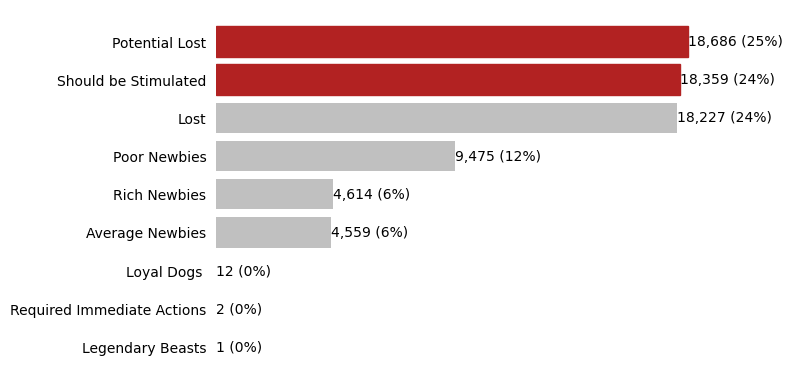

In [399]:
segments_counts = rfm['new_segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['Should be Stimulated', 'Potential Lost']:
            bar.set_color('firebrick')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )

plt.show()

### Ответ на задание 6:
Итак, видим, что у нас мало лояльных покупателей за 2018 год и конец 2017. Можно увеличить их число путем создания соответствующей РК для сегментов __Potential Lost__ и __Should be Stimulated__.  
Также видно, что за 2018 год и конец 2017 года __было потеряно 24% покупателей__. Можно проанализировать возможные причины потери покупателей и не допустить возникновение потенциальных потерь (либо предпринять действия по подогреву покупателей) в сегментах __Poor, Rich, Average Newbies__. 